In [1]:
#!pip install orm
#!pip install pony
#!pip install wordcloud
import sqlite3
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
        display: table-cell;
        text-align: center;
        margin:auto;
    }
.output_html {
        display: table-cell;
        text-align: center;
        margin:auto;
    }
.output_area {
        display: table-cell;
        text-align: center;
        margin:auto;
    }

</style>
""")
#from datetime import datetime

In [2]:
conn = sqlite3.connect('tweets.sqlite')
cliente=1

In [3]:
cur = conn.cursor()
sql = ("SELECT datatime_reacao,sentimento FROM reacao where id_cliente = " + str(cliente) + " and sentimento=1")
df_p = pd.read_sql_query(sql, conn) 
#pd.set_option('max_colwidth',150)
df_p['Semana']=pd.to_datetime(df_p['datatime_reacao']).dt.week
#df_p['Semana']=pd.to_datetime(df_p['datatime_reacao'], unit='s').dt.week
df_p.pop('datatime_reacao')
df_p.pop('sentimento')
df_p['Positivo']='Positivo'

In [4]:
cur = conn.cursor()
sql = ("SELECT datatime_reacao,sentimento FROM reacao where id_cliente = " + str(cliente) + " and sentimento=-1")
df_n = pd.read_sql_query(sql, conn) 
df_n['Semana']=pd.to_datetime(df_n['datatime_reacao']).dt.week
df_n.pop('datatime_reacao')
df_n.pop('sentimento')
df_n['Negativo']='Negativo'
#df_n.groupby('Semana').count().T

In [5]:
df_graf_p = df_p.groupby('Semana').count()

In [6]:
df_graf_n = df_n.groupby('Semana').count()

In [7]:
df_graf = pd.concat([df_graf_p, df_graf_n], axis=1)
df_graf = df_graf.fillna(0)

In [8]:
aux = df_graf['Positivo'].max().astype(int)
if math.isnan(df_graf['Negativo'].max())==False:
    if aux < df_graf['Negativo'].max().astype(int):
        aux = df_graf['Negativo'].max().astype(int)

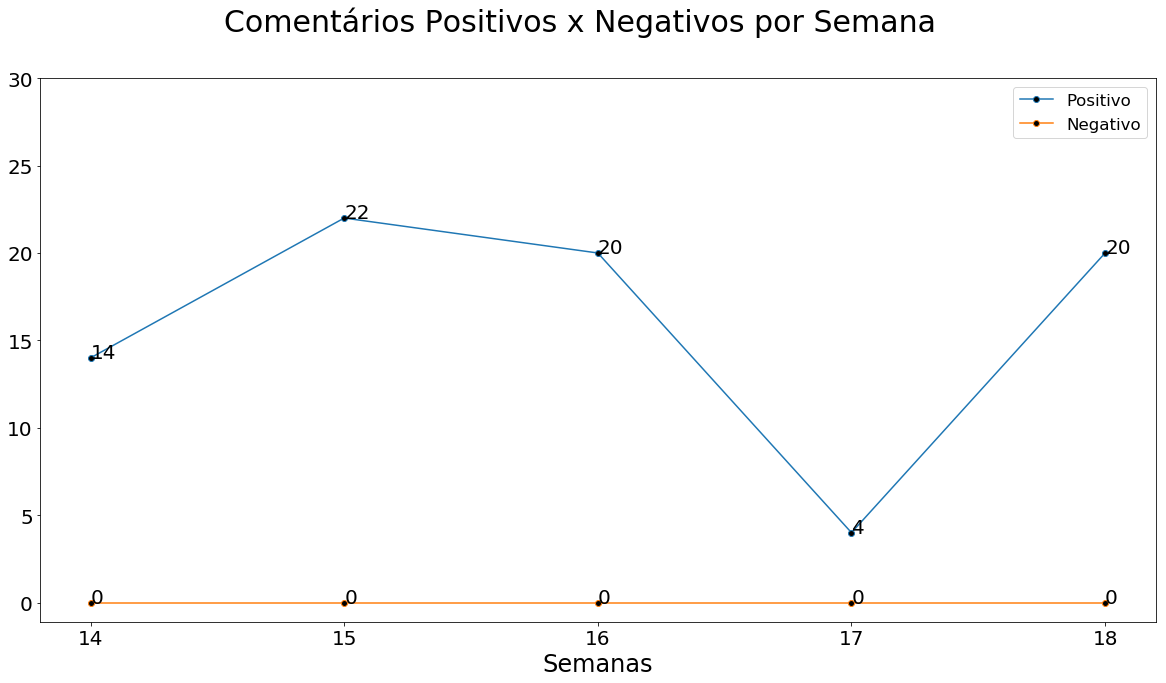

In [9]:
df_graf.plot(linestyle='-', marker='o', markerfacecolor='black',figsize=(20,10))
plt.rc("font", size=20)
plt.suptitle('Comentários Positivos x Negativos por Semana', fontsize=30)
x=df_graf.groupby('Semana').count().T.columns.values
y=range(0,int(aux+10),5)
plt.xticks(x, size=20)
plt.yticks(y, size=20)

p=df_graf.Positivo.T.values
n=df_graf.Negativo.T.values

for xp in zip(x, p): 
    plt.annotate('%s' % str(int(xp[1])), xy=xp, textcoords='data') 

for xn in zip(x, n): 
    plt.annotate('%s' % str(int(xn[1])), xy=xn, textcoords='data') 

plt.xlabel("Semanas", size=24)
plt.legend(fontsize='small')
plt.show()

In [10]:
df_graf['% Positivo'] = round(df_graf.Positivo/(df_graf.Positivo + df_graf.Negativo)*100,2)
df_graf['% Negativo'] = round(df_graf.Negativo/(df_graf.Positivo + df_graf.Negativo)*100,2)

In [11]:
def posicao_rotulo(posicao,valor):
    tamanho = {5:0.065,4:0.055,3:0.0375}
    valor = str(valor)
    return posicao - float(tamanho.get(len(valor)))

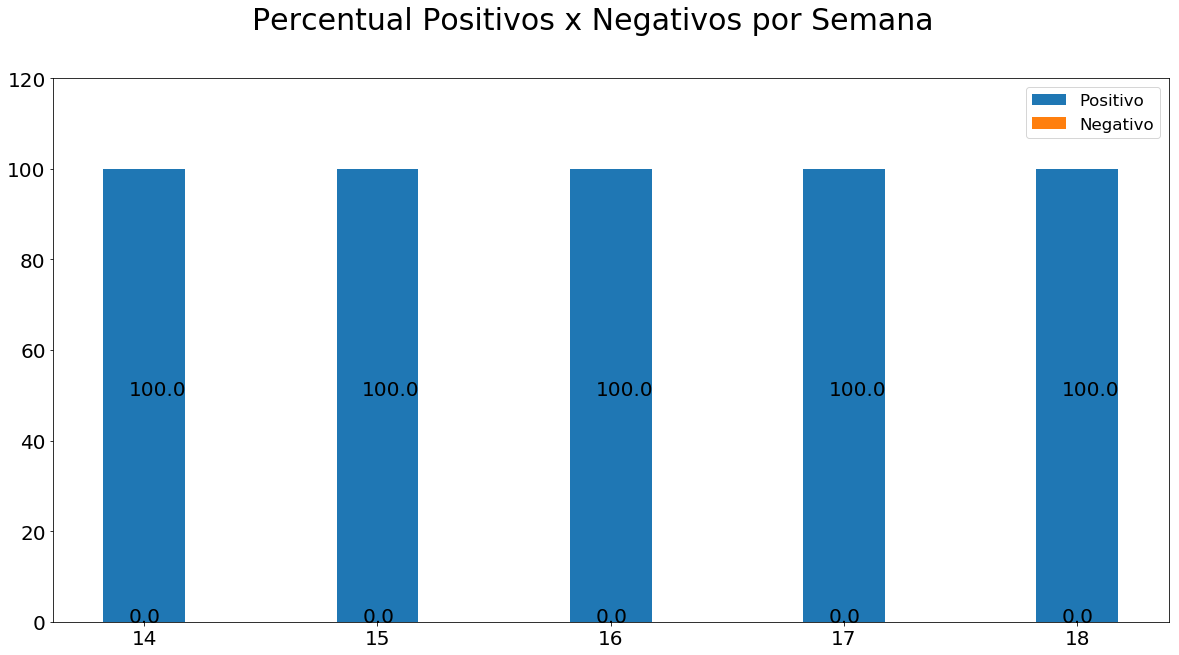

In [12]:
import numpy as np

x = np.array([100.0])
ind =df_graf.groupby('Semana').count().T.columns.values

plt.figure(figsize=(20,10))
plt.suptitle('Percentual Positivos x Negativos por Semana', fontsize=30)
p1 = plt.bar(ind, np.repeat(x, [len(ind)], axis=0), 0.35)
p2 = plt.bar(ind, df_graf['% Negativo'].T.values, 0.35)

p=df_graf['% Positivo'].T.values
n=df_graf['% Negativo'].T.values

for xp in zip(ind, p): 
    plt.annotate('%s' % str(round(xp[1],2)), xy=xp, xytext=(posicao_rotulo(xp[0],xp[1]), 100-(xp[1]/2)), textcoords='data') 

for xn in zip(ind, n): 
    plt.annotate('%s' % str(round(xn[1],2)), xy=xn, xytext=(posicao_rotulo(xn[0],xp[1]), xn[1]/2),textcoords='data') 
    
plt.xticks(ind, size=20)
plt.yticks([0,20,40,60,80,100,120], size=20)
plt.legend((p1, p2), ('Positivo', 'Negativo'),fontsize='small')
plt.show()

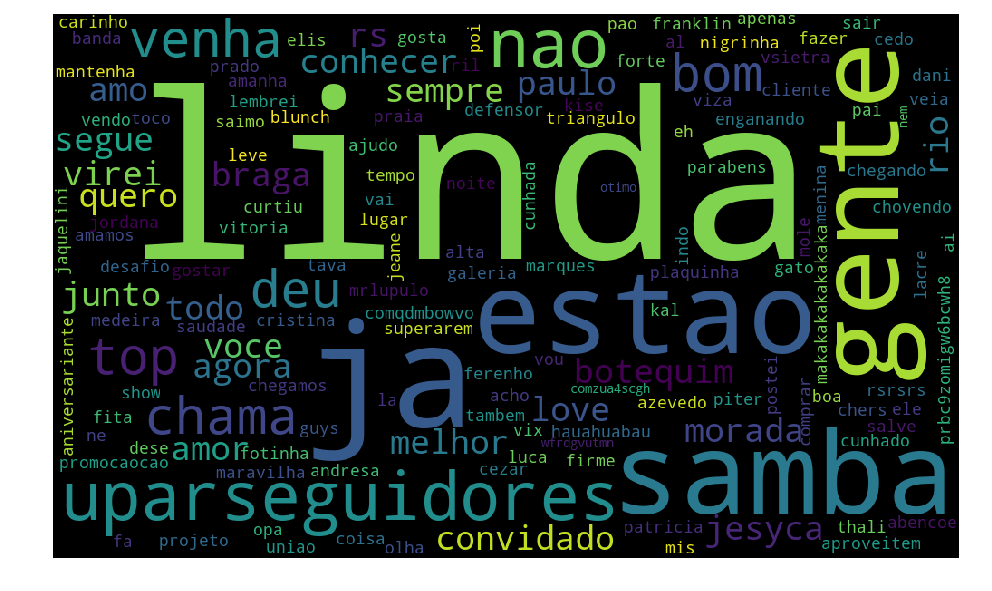

In [16]:
cur = conn.cursor()
sql = ("SELECT feature_classifier FROM reacao where id_cliente = " + str(cliente) + " and sentimento=1")
cur.execute(sql)
lst_wordcloud = cur.fetchall()
aux_wordcloud=[]

for sentence in lst_wordcloud:
    sentence = sentence[0]
    sentence = sentence.replace("[", "")
    sentence = sentence.replace("]", "")
    sentence = sentence.split(", ")
    for i in sentence:
        aux_wordcloud.append(i)
        

wordcloud = WordCloud(relative_scaling = 1.0,width=1000,height=600
                      ).generate(" ".join(aux_wordcloud))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()



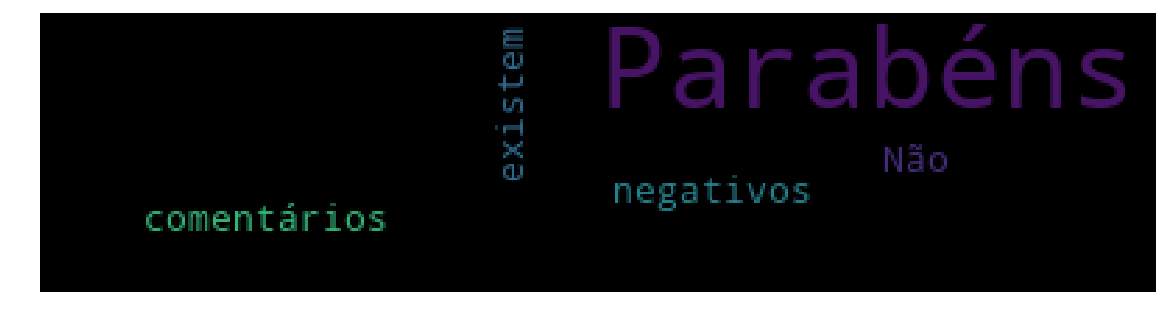

In [17]:
cur = conn.cursor()
sql = ("SELECT feature_classifier FROM reacao where id_cliente = " + str(cliente) + " and sentimento=-1")
cur.execute(sql)
lst_wordcloud = cur.fetchall()
aux_wordcloud=[]
words=''

if len(lst_wordcloud)>0:
    for sentence in lst_wordcloud:
        sentence = sentence[0]
        sentence = sentence.replace("[", "")
        sentence = sentence.replace("]", "")
        sentence = sentence.split(", ")
        for i in sentence:
            aux_wordcloud.append(i)
    
    words=" ".join(aux_wordcloud)
    wordcloud = WordCloud(relative_scaling = 1.0,width=1000,height=600).generate(words)
    plt.figure(figsize=(20,10)) 
else:
    words='Não existem comentários negativos. Parabéns Parabéns Parabéns'
    wordcloud = WordCloud(relative_scaling = 1.0,width=400,height=100).generate(words)
    plt.figure(figsize=(20,10))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [15]:
cur = conn.cursor()
sql = ("SELECT datatime_reacao, reacao, fonte as [Rede Social] FROM reacao, fonte where fonte.id = reacao.id_fonte and id_cliente = " + str(cliente) + " and sentimento=-1 order by datatime_reacao desc")
df_n = pd.read_sql_query(sql, conn) 
df_n['Semana']=pd.to_datetime(df_n['datatime_reacao']).dt.week
df_n['Data']=pd.to_datetime(df_n['datatime_reacao']).dt.strftime('%d/%m/%Y %H:%M')
df_n['Comentário']=df_n['reacao']
df_n.pop('reacao')
df_n.pop('datatime_reacao')
pd.set_option('max_colwidth',150)
d = dict(selector="th",
    props=[('text-align', 'center')])

df_n.style.set_properties(**{'text-align':'center'}).set_table_styles([d])
#df_n

,Rede Social,Semana,Data,Comentário
